Tracked indices: [184, 294, 237]
Tracked coordinates: [array([5., 0., 0.]), array([ 5., 20.,  0.]), array([ 5., 40.,  0.])]
InflatableSheet setVars	0.00848198	1
Newton iterations	81.8431	1
    InflatableSheet energy	0.000469208	1
    Newton iterate	81.8421	115
        Backtracking	0.602833	114
            InflatableSheet energy	0.109458	175
            InflatableSheet setVars	0.483216	175
        Compute descent direction	79.1635	114
            Negative curvature dir	0.233032	3
                negativeCurvatureDirection	0.224021	3
                    CHOLMOD Backsub	0.154122	51
                    CHOLMOD Numeric Factorize	0.00357199	3
                    CHOLMOD Symbolic Factorize	0.0372722	3
            newton_step	78.9296	114
                Newton solve	75.5042	194
                    CHOLMOD Numeric Factorize	72.8833	193
                    Solve	1.57763	115
                        CHOLMOD Backsub	1.1315	114
                        CHOLMOD Numeric Factorize	0.122032	1
           

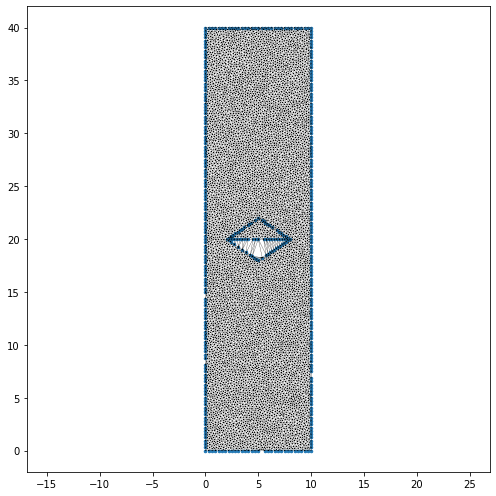

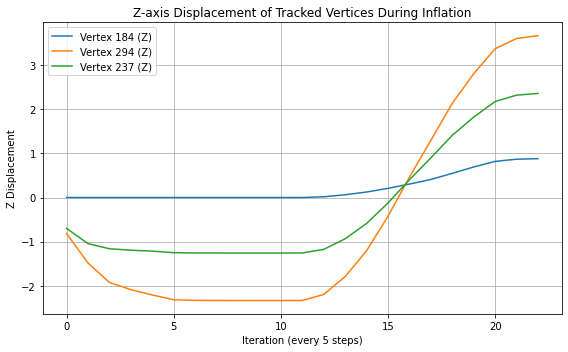

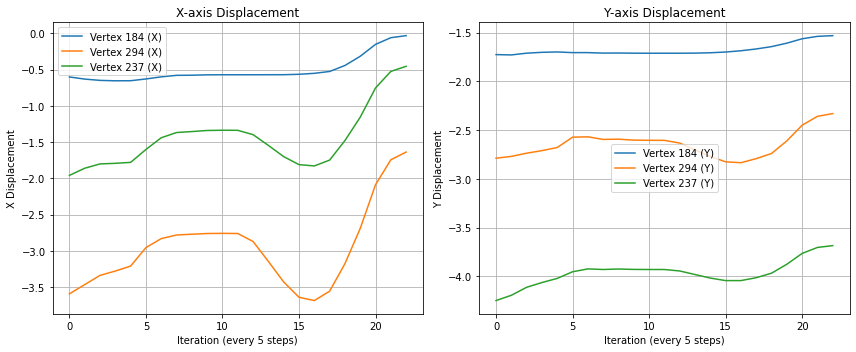

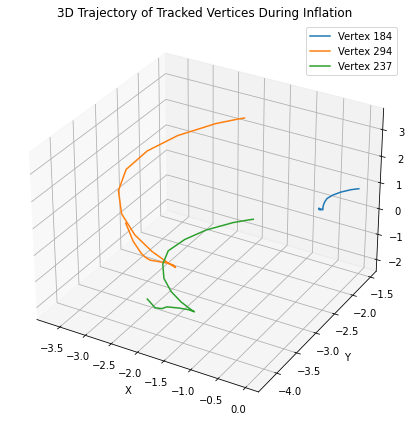

In [1]:
import sys; sys.path.append('..')
import inflation, mesh, sheet_meshing
from tri_mesh_viewer import TriMeshViewer as Viewer
import triangulation
import numpy as np
import utils, py_newton_optimizer, benchmark
import visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import KDTree

# --- Load mesh and set up simulation ---
V, E = mesh.load_raw('data/ForwardDesign/hinge.obj')
fusedPts = list(np.loadtxt('data/ForwardDesign/fusehingev3.txt').reshape((-1, 2)))
holePts = []

m, iwv, iwbv = sheet_meshing.forward_design_mesh(V, E, fusedPts, holePts, np.prod(utils.bbox_dims(V)[0:2]) / 1e4)
isheet = inflation.InflatableSheet(m, iwv)

visualization.plot_2d_mesh(m, pointList=np.where(iwv))
viewer = Viewer(isheet, wireframe=True)
viewer.show()

# --- Define and find tracked vertices ---
target_points = np.array([
    [5.0,  0.0, 0.0],
    [5.0, 20.0, 0.0],
    [5.0, 40.0, 0.0]
])
V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])
tree = KDTree(V_rest)
tracked_indices = [tree.query(p)[1] for p in target_points]
print("Tracked indices:", tracked_indices)
print("Tracked coordinates:", [V_rest[i] for i in tracked_indices])

# --- Tracking setup ---
trajectory = {idx: [] for idx in tracked_indices}
framerate = 5

def cb(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        viewer.update()

# --- Run simulation ---
benchmark.reset()
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.niter = 500
isheet.pressure = 1
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)
benchmark.report()

# --- Plot Z displacement ---
plt.figure(figsize=(8, 5))
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 2], label=f"Vertex {idx} (Z)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("Z Displacement")
plt.title("Z-axis Displacement of Tracked Vertices During Inflation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot X and Y displacement ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 0], label=f"Vertex {idx} (X)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("X Displacement")
plt.title("X-axis Displacement")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 1], label=f"Vertex {idx} (Y)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("Y Displacement")
plt.title("Y-axis Displacement")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 3D Trajectory Plot ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D Trajectory of Tracked Vertices During Inflation")
ax.legend()
plt.tight_layout()
plt.show()